# Hidden Markov Models for event segmentation

Hidden Markov Models (HMM) allow us to temporally cluster brain activity into discrete events, and to identify event correspondences between datasets. This tutorial describes how to fit HMMs to a narrative dataset, how to statistically verify the identified event boundaries, how to align multiple datasets, and how to apply HMMs to connectivity data. A full description of the model is given in [the Neuron paper](http://www.dpmlab.org/Neuron17.pdf).

In [1]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

## Fitting HMM to activity patterns

The goal of the HMM is to identify chunks of time during which activity patterns remain relatively constant. To see if this is a reasonable model for our dataset, we can plot a timepoint-timepoint correlation matrix, showing the similarity between every pair of timepoints in our dataset (averaged over subjects).

In [2]:
temp=np.load("reduced_more.npy")
reservoir_data=temp.T
print(reservoir_data.shape)

(1380, 22)


In [3]:
# ground truth values: 
#32, 61, 96, 129, 158, 188, 212, 248, 274, 307, 329, 354, 376, 408, 431, 460, 483, 503, 526, 548, 573, 600, 626, 650, 
#248 341 377 466 500 589 614 703 736 833 853 947 968 1061 1089 1179 1201 1292

In [105]:
#bounds_ground = [32, 61, 96, 129, 158, 188, 212, 248, 274, 307, 329, 354, 376, 408, 431, 460, 483, 503, 526, 548, 573, 600, 626, 650]
#print(bounds_ground)
bounds_ground = [248, 341, 377, 466, 500, 589, 614, 703, 736, 833, 853, 947, 968, 1061, 1089, 1179, 1201, 1292]
print(bounds_ground)

start_ground = [248,  377,  500,  614,  736,  853,  968,  1089, 1201]
                 

[248, 341, 377, 466, 500, 589, 614, 703, 736, 833, 853, 947, 968, 1061, 1089, 1179, 1201, 1292]


/home/peter/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/peter/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


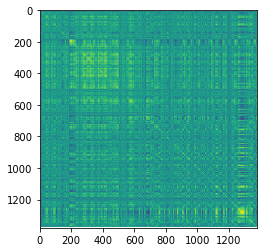

In [5]:
plt.imshow(np.corrcoef(reservoir_data[:,1:10]),cmap='viridis')


In [101]:
# 2 set up the segmentation HMM
ev2 = brainiak.eventseg.event.EventSegment(12)
ev2.fit(reservoir_data[:,2:4])

#nTR is the number of TRs in the data
nTR=1380

In [102]:
print(ev2.event_var_)

0.7787034923215993


/home/peter/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/peter/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


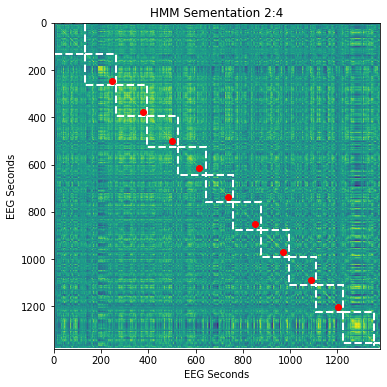

In [106]:
# 3 display the segmentation

bounds = np.where(np.diff(np.argmax(ev2.segments_[0], axis=1)))[0]
nTR=1379
plt.figure(figsize=(6,6))
plt.imshow(np.corrcoef(reservoir_data[:,1:10]),cmap='viridis')
#plt.imshow(np.corrcoef(reservoir_data),cmap='gist_rainbow')
ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2, linestyle='--',edgecolor='w',facecolor='none')
    ax.add_patch(rect)

for i in start_ground:
    plt.plot(i,i,'ro') 
plt.title("HMM Sementation 2:4")
plt.xlabel('EEG Seconds')
plt.ylabel('EEG Seconds')
plt.savefig('EEG_2-4-start.png')

In [110]:
ground = np.array(start_ground)
print(bounds)
print(ground)

[ 131  263  396  526  644  760  876  993 1109 1223 1354]
[ 248  377  500  614  736  853  968 1089 1201]


p = 5.183429891713925e-06


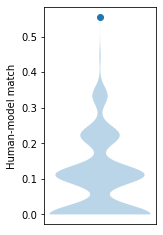

In [115]:
#bounds = bounds3
human_bounds = ground+25
np.random.seed(0)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in human_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(human_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))

## Aligning movie and recall data

A simple model of free recall is that a subject will revisit the same sequence of events experienced during perception, but the lengths of the events will not be identical between perception and recall. We can fit this model by separately estimating event boundaries in movie and recall data, while constraining the event patterns to be the same across the two datasets.

We will now download fMRI data from the angular gyrus, consisting of (group average) movie-watching data, and free recall data for a single subject. We also have a human-labeled correspondence between the movie and the recall (based on the transcript of the verbal recall). The full dataset for all 17 subjects is [available here](https://ndownloader.figshare.com/files/9055471).

In [ ]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(ev.segments_[0].T,aspect='auto',cmap='jet') #origin='lower',
plt.xlabel('fMRI TRs')
plt.ylabel('Events')

plt.subplot(1,2,2)
plt.imshow(ev2.segments_[0].T,aspect='auto',cmap='jet')
plt.xlabel('Reservoir States')
plt.ylabel('Events')
plt.savefig('hmm_notthefall_fmri-reservoir.png')

To get the temporal correspondence between the movie and the recall, we need to find the probability that a movie TR and a recall TR are in the same event (regardless of which event it is). This is
$$
\sum_k p(T_M == k) \cdot p(T_R == k)
$$
which we can compute by a simple matrix multiplication.

For comparison, we also plot the human-labeled correspondence as white boxes.

In [ ]:
# try with our data
plt.figure(figsize=(6,5))
#plt.imshow(np.dot(ev2.segments_[0], ev.segments_[0].T).T,aspect='auto',origin='lower')
plt.imshow(np.dot(ev.segments_[0], ev2.segments_[0].T).T,aspect='auto',cmap='jet')#origin='lower',


plt.xlabel('fMRI TRs')
plt.ylabel('Reservoir TRs')
plt.savefig('hmm_notthefall_fmri-reservoir-dot.png')

In [ ]:
ev11 = brainiak.eventseg.event.EventSegment(10)
ev11.fit(not_the_fall[:,50000:60000])
bounds11 = np.where(np.diff(np.argmax(ev11.segments_[0], axis=1)))[0]


In [ ]:
ev21 = brainiak.eventseg.event.EventSegment(10)
ev21.fit(reservoir_data)
bounds21 = np.where(np.diff(np.argmax(ev21.segments_[0], axis=1)))[0]


In [ ]:
ev12 = brainiak.eventseg.event.EventSegment(20)
ev12.fit(not_the_fall[:,50000:60000])
bounds12 = np.where(np.diff(np.argmax(ev12.segments_[0], axis=1)))[0]

In [ ]:
ev22 = brainiak.eventseg.event.EventSegment(20)
ev22.fit(reservoir_data)
bounds22 = np.where(np.diff(np.argmax(ev22.segments_[0], axis=1)))[0]

In [ ]:
ev13 = brainiak.eventseg.event.EventSegment(30)
ev13.fit(not_the_fall[:,50000:60000])
bounds13 = np.where(np.diff(np.argmax(ev13.segments_[0], axis=1)))[0]

In [ ]:
ev23 = brainiak.eventseg.event.EventSegment(30)
ev23.fit(reservoir_data)
bounds23 = np.where(np.diff(np.argmax(ev23.segments_[0], axis=1)))[0]

In [ ]:
ev14 = brainiak.eventseg.event.EventSegment(40)
ev14.fit(not_the_fall[:,50000:60000])
bounds14 = np.where(np.diff(np.argmax(ev14.segments_[0], axis=1)))[0]

In [ ]:
ev24 = brainiak.eventseg.event.EventSegment(40)
ev24.fit(reservoir_data)
bounds24 = np.where(np.diff(np.argmax(ev24.segments_[0], axis=1)))[0]

In [ ]:
data1 = ((bounds11/400 - bounds21/682)*400)
data2 = ((bounds12/400 - bounds22/682)*400)
data3 = ((bounds13/400 - bounds23/682)*400)
data4 = ((bounds14/400 - bounds24/682)*400)

data_to_plot = [data1,data2,data3,data4]

fig, ax1 = plt.subplots(figsize=(12, 5))                      

plt.subplot(1,1,1)
plt.boxplot( data_to_plot,showmeans=True)

plt.show()

In [ ]:
#data1 = abs((bounds11/400 - bounds21/682)*400)
data1b = abs((bounds11/400 - bounds21/682)*400)
data2b = abs((bounds12/400 - bounds22/682)*400)
data3b = abs((bounds13/400 - bounds23/682)*400)
data4b = abs((bounds14/400 - bounds24/682)*400)

data_to_plot_before = [data1b,data2b,data3b,data4b]

fig, ax1 = plt.subplots(figsize=(12, 5))                      

plt.subplot(1,1,1)
plt.boxplot( data_to_plot_before,showmeans=True)

plt.show()

In [ ]:
We then measured, for each region, what fraction of its fMRI-defined boundaries were close to (within three
time points of) a consensus event boundary.

for 

In [ ]:
bounds11_min= np.empty(len(bounds11))
for i in range(len(bounds11)):
    bounds11_min[i]=1000
    for j in range(len(bounds21)):
        test=abs(bounds11[i]/400-bounds21[j]/682)
        if test < bounds11_min[i]:
            bounds11_min[i] = test          

In [ ]:
bounds12_min= np.empty(len(bounds12))
for i in range(len(bounds12)):
    bounds12_min[i]=1000
    for j in range(len(bounds22)):
        test=abs(bounds12[i]/400-bounds22[j]/682)
        if test < bounds12_min[i]:
            bounds12_min[i] = test
            

In [ ]:
bounds13_min= np.empty(len(bounds13))
for i in range(len(bounds13)):
    bounds13_min[i]=1000
    for j in range(len(bounds23)):
        test=abs(bounds13[i]/400-bounds23[j]/682)
        if test < bounds13_min[i]:
            bounds13_min[i] = test
            

In [ ]:
bounds14_min= np.empty(len(bounds14))
for i in range(len(bounds14)):
    bounds14_min[i]=1000
    for j in range(len(bounds24)):
        test=abs(bounds14[i]/400-bounds24[j]/682)
        if test < bounds14_min[i]:
            bounds14_min[i] = test
            

In [ ]:
print(len(bounds))
print(len(bounds_ground))

In [ ]:
bounds_ntf_min= np.empty(len(bounds_ground))
for i in range(len(bounds_ground)):
    bounds_ntf_min[i]=1000
    for j in range(len(bounds)):
        test=abs(bounds_ground[i]-bounds[j])
        if test < bounds_ntf_min[i]:
            bounds_ntf_min[i] = test
            

In [ ]:

print(bounds)
print(bounds_ground)
#print(bounds_ground - bounds)
print(bounds_ntf_min)


In [ ]:
print(stats.describe(bounds_ntf_min))

In [ ]:
#data1 = abs((bounds11/400 - bounds21/682)*400)
data1 = bounds11_min*400
data2 = bounds12_min*400
data3 = bounds13_min*400
data4 = bounds14_min*400

data_to_plot = [data1b,data1,data2b,data2,data3b, data3,data4b,data4]

fig, ax1 = plt.subplots(figsize=(12, 5))                      

plt.subplot(1,1,1)
plt.boxplot( data_to_plot,showmeans=True)

plt.show()

In [ ]:
#data1 = abs((bounds11/400 - bounds21/682)*400)
data1 = bounds11_min*400
data2 = bounds12_min*400
data3 = bounds13_min*400
data4 = bounds14_min*400

data_to_plot = [data2,data3,data4]

fig, ax1 = plt.subplots(figsize=(12, 5))                      

plt.subplot(1,1,1)
plt.hist( data_to_plot)

plt.show()

In [ ]:
#print("{:.2f}".format(bounds21/682))
print((bounds12))
print((bounds22))
print((abs(bounds12/400-bounds22/682))*400)
print((bounds12_min)*400)